In [8]:
from google.colab import drive
import os, shutil
import pathlib
from pathlib import Path


import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix

In [2]:
zip_name = "images.zip"

# --- Step 2: Extract ZIP ---
import zipfile, os

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall("/content")

dataset_root = "/content/images"

print("Dataset extracted to:", dataset_root)


# L'ensemble de données contient 1500 images de déchets recyclables réparties en 3 catégories :Plastic, Paper, Cans
# Source: Kaggle Recyclable and Household Waste Classification

Dataset extracted to: /content/images


In [3]:
# Fonction pour diviser L'ensemble de données: 70% training, 20% validation, 10% testing

def create_splits(root_dir, split_root="dataset_split"):

    output_root = f"/content/{split_root}"
    classes = os.listdir(root_dir)

    # Création des sous dossier (ex: /content/images/train)
    for split in ["train", "val", "test"]:
        for cls in classes:
            os.makedirs(os.path.join(output_root, split, cls), exist_ok=True)

    # Cette section est conçue pour gérer un ensemble de données où les images d'une même classe peuvent être organisées en sous-dossiers.
    # Dans ce cas notre dataset contien 2 sous dossiers (real_world, default) pour chaque classe
    for cls in classes:
        cls_path = os.path.join(root_dir, cls)

        # Load all images in class
        images = []
        for folder_name in os.listdir(cls_path):
            folder_path = os.path.join(cls_path, folder_name)
            if os.path.isdir(folder_path):
                for img_file in os.listdir(folder_path):
                    images.append(os.path.join(folder_path, img_file))

        images = np.array(images)

        # 70/20/10 split
        train_imgs, temp_imgs = train_test_split(images, test_size=0.30, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=1/3, random_state=42)

        # Copy files
        for img in train_imgs:
            shutil.copy(img, f"{output_root}/train/{cls}")
        for img in val_imgs:
            shutil.copy(img, f"{output_root}/val/{cls}")
        for img in test_imgs:
            shutil.copy(img, f"{output_root}/test/{cls}")

    return output_root

split_path = create_splits(dataset_root)
split_path


'/content/dataset_split'

In [4]:
img_size = (224, 224)
batch_size = 32

# Cette finction permet de générer rapidement un objet tf.data.Dataset à partir de fichiers image organisés par structure de répertoires.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_path, "train"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical" # Classification
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_path, "val"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_path, "test"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_ds.class_names
class_names


Found 681 files belonging to 3 classes.
Found 267 files belonging to 3 classes.
Found 147 files belonging to 3 classes.


['cans', 'paper', 'plastic']

In [5]:
# Notion de prefetch pour augmenter les performances
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [6]:
# Étant donné la petite taille de l'ensemble de données (1500 images totale), nous utiliserons l'augmentation des données.
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [9]:
from tensorflow.keras.applications import MobileNetV2

# Charger MobileNetV2 (sans la tête finale + freeze)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Geler les couches du modèle pré-entraîné

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.4839 - loss: 1.1284 - val_accuracy: 0.7903 - val_loss: 0.5511
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7296 - loss: 0.6569 - val_accuracy: 0.8652 - val_loss: 0.3774
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.8030 - loss: 0.4859 - val_accuracy: 0.9139 - val_loss: 0.3004
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8552 - loss: 0.3768 - val_accuracy: 0.9326 - val_loss: 0.2575
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.8702 - loss: 0.3280 - val_accuracy: 0.9401 - val_loss: 0.2251
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8740 - loss: 0.3302 - val_accuracy: 0.9401 - val_loss: 0.1999
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.9037 - loss: 0.2950 - val_accuracy: 0.9438 - val_loss: 0.1935
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9075 - loss: 0.2586 - val_accuracy: 0.955

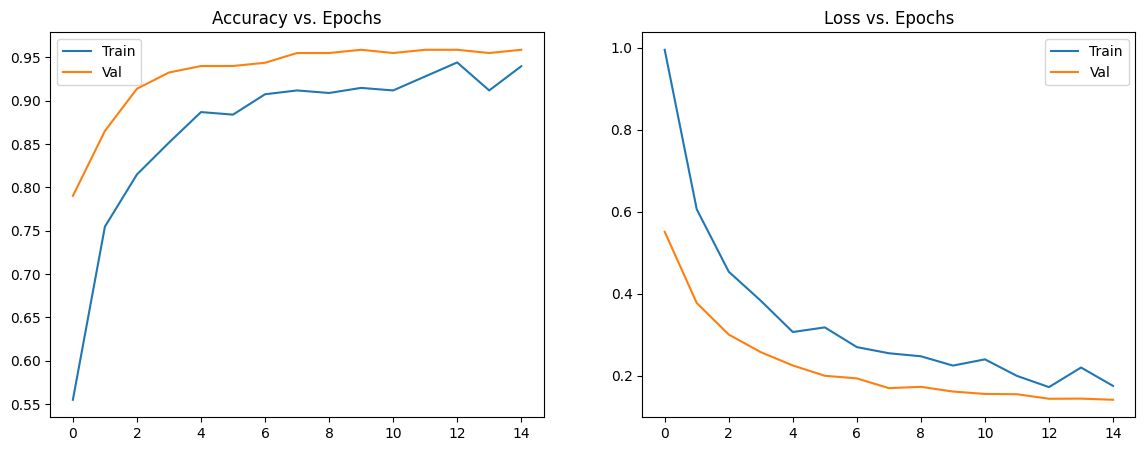

In [11]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs. Epochs")
plt.legend(["Train", "Val"])

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs. Epochs")
plt.legend(["Train", "Val"])

plt.show()


In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9440 - loss: 0.2112
Test accuracy: 0.9387755393981934
Test loss: 0.21934013068675995


In [13]:
model.save("waste_classifier.h5")


In [14]:
def representative_data_gen():
    for images, _ in train_ds.take(50):  # use 50 batches for calibration
        yield [images.numpy()]


In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Full INT8 quantization settings
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Force input/output to int8 (Raspberry Pi friendly)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("waste_classifier_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("✓ TFLite model saved successfully!")


Saved artifact at '/tmp/tmpihqigypx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_320')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137540290890256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290891024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290890832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290888336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290891600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290888528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290891216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290891408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290888912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137540290892560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1375402908

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✓ TFLite model saved successfully!


In [17]:
interpreter = tf.lite.Interpreter(model_path="waste_classifier_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)


[{'name': 'serving_default_keras_tensor_320:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 176, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Interprétation des résultats:

Le modèle est plus performant sur le plastique, car ses formes sont bien distinctes.

Le papier et les canettes peuvent se chevaucher visuellement selon l'éclairage et l'arrière-plan.

Les courbes d'entraînement et de validation montrent :

Une diminution stable de la perte

Une précision de validation assez bien

Absence de surapprentissage important grâce à RandomFlip, RandomRotation et Dropout

Globalement, le CNN apprend avec succès à classer les déchets recyclables (70% accuraccy) vu le manque de données.